In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import pathlib
from google.cloud import storage
import tensorflow_hub as hub
from io import BytesIO
from tensorflow.python.lib.io import file_io
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [2]:
train_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren_4classes_balanced.csv", header=None)
val_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren_grouped_classes_balanced.csv", header=None)
test_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren_grouped_classes_balanced.csv", header=None)
CLASS_NAMES = train_data[0].unique()

In [3]:
# train_data.to_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_augment_siebren2.csv", header=None, index=None)

In [4]:
# train_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_augment_siebren2.csv", header=None)

In [5]:
# def check_data(data):
#     no_series = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/data_without_series.csv")
#     z_score = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/data_without_zScore.csv")
#     overexposed = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/overexposed.csv")
#     underexposed = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/underexposed.csv")
    
#     data[1] = data[1].map(lambda x: x.lstrip('../gabon-dataset/data_training_rescaled_extra/'))
#     new_data = no_series.merge(data, left_on='pictures', right_on=1)
#     new_data = new_data[[0, 1]]
#     new_data[1] = '../gabon-dataset/data_training_rescaled_extra/' + new_data[1]
#     return new_data       

In [6]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

BATCH_SIZE = 128
# 10 is a magic number tuned for local training of this dataset.
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_IMAGES = 370
VALIDATION_STEPS = VALIDATION_IMAGES // BATCH_SIZE

In [7]:
def decode_img(img, reshape_dims):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

In [8]:
MAX_DELTA = 63.0 / 255.0  # Change brightness by at most 17.7%
CONTRAST_LOWER = 0.2
CONTRAST_UPPER = 1.8
img_list = []

def read_and_preprocess(image_bytes, label, augment):
    if augment == "True":
        img = decode_img(image_bytes, [IMG_HEIGHT + 10, IMG_WIDTH + 10])
        img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, MAX_DELTA)
        img = tf.image.random_contrast(img, CONTRAST_LOWER, CONTRAST_UPPER)
    else:
        img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
    return img, label


In [9]:
def decode_csv(csv_row):
    record_defaults = ["img", "path", "augment"]
    
    label_string, filename, augment = tf.io.decode_csv(csv_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    label = tf.math.equal(CLASS_NAMES, label_string)

    return image_bytes, label, augment

In [10]:
def load_dataset(csv_of_filenames, batch_size, training=True):    
    dataset = tf.data.TextLineDataset(filenames=csv_of_filenames) \
        .map(decode_csv, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset \
        .map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
        .repeat(count=1)  # Each photo used once.
    
    # Prefetch prepares the next set of batches while current batch is in use.
    return dataset.batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)
#     return dataset.range(4).interleave(lambda _: dataset.batch(batch_size=batch_size), num_parallel_calls=tf.data.AUTOTUNE )

# Model

In [11]:
# data
train_path = "gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren_4classes_balanced.csv"
eval_path = "gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren_4classes_balanced.csv"
nclasses = len(CLASS_NAMES)

In [12]:
base_model = keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [13]:
base_model.trainable = False

In [14]:
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(rate=0.5)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nclasses, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
# model = keras.models.load_model("gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_augmented_balanced/model.H5")
# model.load_weights("gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_4classes/cp.ckpt")

In [17]:
# model.layers[1].trainable = False

In [18]:
# model.summary()

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [20]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_augmented_grouped4x_balanced/cp.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

In [21]:
history = model.fit(train_ds,
            epochs=3,
#             steps_per_epoch=(len(train_data) // BATCH_SIZE),
            validation_data=eval_ds,
            callbacks=[cp_callback]
#             validation_steps=(len(val_data) // BATCH_SIZE)
         )

Epoch 1/3
5284/5284 [==============================] - 3494s 660ms/step - loss: 0.4038 - accuracy: 0.8547 - val_loss: 0.1951 - val_accuracy: 0.9370

Epoch 00001: saving model to gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_augmented_grouped4x_balanced/cp.ckpt
Epoch 2/3
5284/5284 [==============================] - 3579s 677ms/step - loss: 0.3329 - accuracy: 0.8825 - val_loss: 0.1931 - val_accuracy: 0.9374

Epoch 00002: saving model to gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_augmented_grouped4x_balanced/cp.ckpt
Epoch 3/3
  75/5284 [..............................] - ETA: 50:22 - loss: 0.3233 - accuracy: 0.8872

KeyboardInterrupt: 

In [129]:
model.trainable = True
BATCH_SIZE = 64

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [ ]:
history = model.fit(train_ds,
            epochs=1,
#             steps_per_epoch=(len(train_data) // BATCH_SIZE),
            validation_data=eval_ds,
#             validation_steps=(len(val_data) // BATCH_SIZE)
         )

# save model

In [22]:
tf.keras.models.save_model(model, "gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_augmented_grouped4x_balanced/model.H5", 
                           include_optimizer=False)

INFO:tensorflow:Assets written to: gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_augmented_grouped4x_balanced/model.H5/assets


# Myanmar_data

In [37]:
test_data_myan = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_myanmar_augment_siebren.csv", header=None)
test_path_myan = "gs://dataset-gabon/train_val_test_csv_Siebren/test_data_myanmar_augment_siebren.csv"
test_ds_myan = load_dataset(test_path_myan, BATCH_SIZE, training=False)

In [38]:
test_loss, test_acc = model.evaluate(test_ds_myan, verbose=1)
print(test_acc)

62/62 [==============================] - 427s 7s/step - loss: 1.4184 - accuracy: 0.6334
0.6334425210952759


In [ ]:
PREDICTIONS = len(test_data_myan)//BATCH_SIZE
y_test = []
counter = 0
for i in tqdm(test_ds_myan):
    if counter < PREDICTIONS:
        counter += 1
        for j in i[1]:
            y_test.append(np.where(j == True)[0][0])
    else:
        break
print(len(y_test))

In [ ]:
# y_pred = model.predict(test_ds_myan, steps=PREDICTIONS)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = y_test
y, idx = tf.unique(predicted_categories)
cm = confusion_matrix(predicted_categories, true_categories, normalize="pred", labels=y.numpy())
cmn = cm
df_cm = pd.DataFrame(cmn, index = [CLASS_NAMES[i] for i in y.numpy()],
                  columns = [CLASS_NAMES[i] for i in y.numpy()])

In [ ]:
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [ ]:
correctly_classified = {}
total = {}
for idx, i in enumerate(true_categories):
    if i == predicted_categories[idx].numpy():
        if CLASS_NAMES[i] in correctly_classified.keys():
            correctly_classified[CLASS_NAMES[i]] += 1
        else:
            correctly_classified[CLASS_NAMES[i]] = 1
    
    if CLASS_NAMES[i] in total.keys():
        total[CLASS_NAMES[i]] += 1
    else:
        total[CLASS_NAMES[i]] = 1
            
print("correct:", correctly_classified)
print("total:  ", total)

In [ ]:
plt.ion()
index = 0
for idx, i in enumerate(test_ds_myan):   
    for j in i[0]:
#         if y_pred[index][y_pred[index].argmax()] > 0.90:
        if predicted_categories[index].numpy() != true_categories[index]:
            plt.figure(figsize = (16,16))
            plt.imshow(j)
            plt.show()
            print("Prediction: "+ str(CLASS_NAMES[predicted_categories[index].numpy()]))
            print("True: "+ str(CLASS_NAMES[true_categories[index]]))
        index+=1

# Results

In [25]:
test_path = "gs://dataset-gabon/train_val_test_csv_Siebren/test_data_augment_siebren.csv"
test_ds = load_dataset(test_path, BATCH_SIZE, training=False)

In [23]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(test_acc)

341/341 [==============================] - 684s 2s/step - loss: 1.6831 - accuracy: 0.5298
0.5298312306404114


In [ ]:
# plot results
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

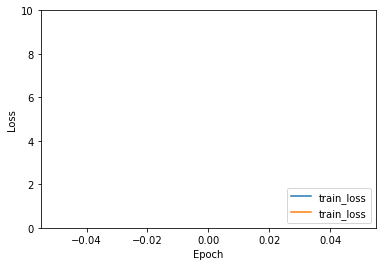

In [26]:
# plot results
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 10])
plt.legend(loc='lower right')

In [26]:
PREDICTIONS = len(test_data)//BATCH_SIZE
y_test = []
counter = 0
for i in tqdm(test_ds):
    if counter < PREDICTIONS:
        counter += 1
        for j in i[1]:
            y_test.append(np.where(j == True)[0][0])
    else:
        break
print(len(y_test))

340it [01:13,  4.60it/s]

43520


In [27]:
y_pred = model.predict(test_ds, steps=PREDICTIONS)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = y_test
cmn = confusion_matrix(predicted_categories, true_categories, normalize="true")

df_cm = pd.DataFrame(cmn, index = [i for i in CLASS_NAMES],
                  columns = [i for i in CLASS_NAMES])

<AxesSubplot:>

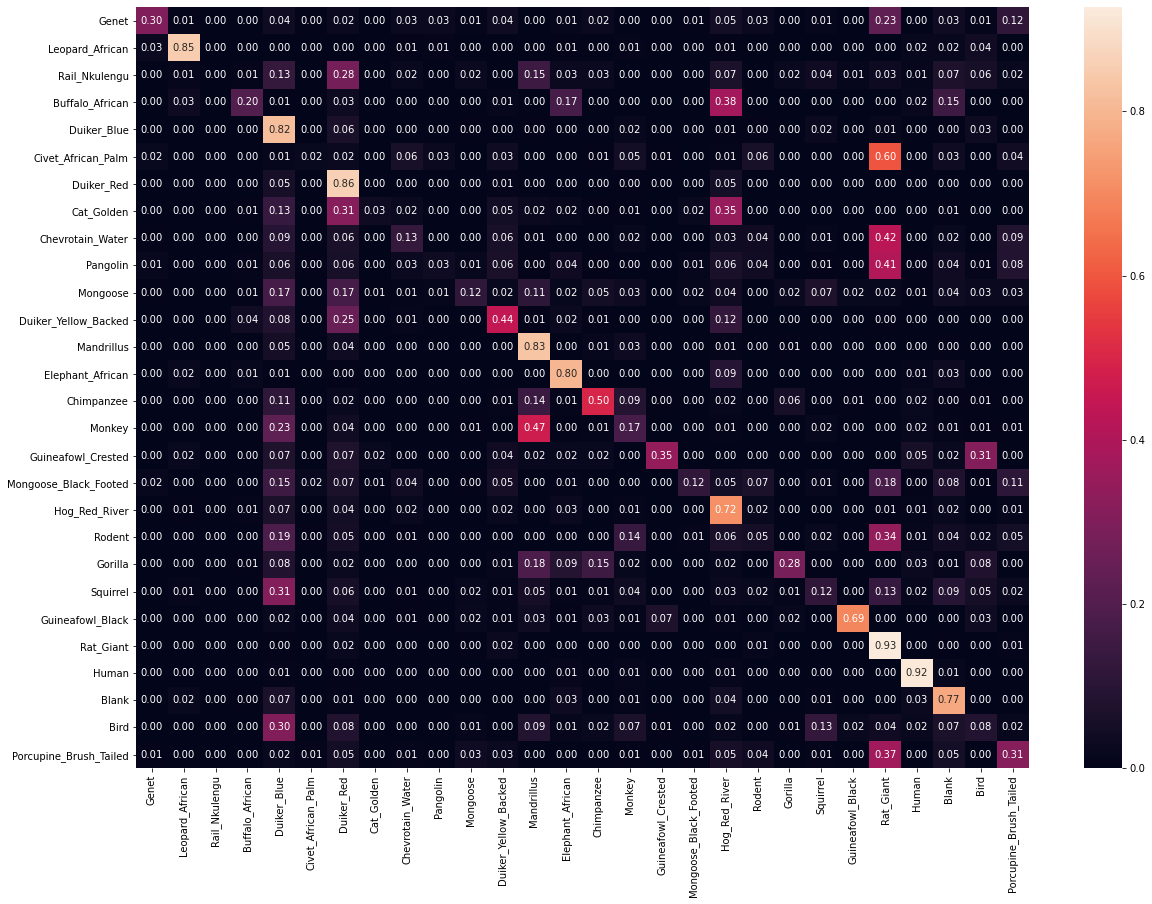

In [28]:
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [50]:
prediction_dict = {'Rat_Giant':[], 'Squirrel':[], 'Duiker_Red':[], 'Rodent':[], 'Human':[],
       'Guineafowl_Black':[], 'Monkey':[], 'Duiker_Blue':[],
       'Duiker_Yellow_Backed':[], 'Elephant_African':[], 'Rail_Nkulengu':[],
       'Bird':[], 'Blank':[], 'Mandrillus':[], 'Chevrotain_Water':[],
       'Porcupine_Brush_Tailed':[], 'Leopard_African':[], 'Mongoose':[],
       'Hog_Red_River':[], 'Chimpanzee':[], 'Guineafowl_Crested':[],
       'Buffalo_African':[], 'Genet':[], 'Mongoose_Black_Footed':[],
       'Civet_African_Palm':[], 'Pangolin':[], 'Gorilla':[], 'Cat_Golden':[]}
index = 0
counter = 0
for idx, i in enumerate(tqdm(test_ds)):
    if counter < PREDICTIONS:
        counter+=1
        for j in i[0]:
            if predicted_categories[index].numpy() != true_categories[index]:
                prediction_dict[CLASS_NAMES[true_categories[index]]].append(predicted_categories[index].numpy())
            index+=1

341it [01:11,  4.77it/s]


In [51]:
for true_classes in prediction_dict.keys():
    classes = []
    for i in range(len(CLASS_NAMES)):
        counter = 0
        for j in prediction_dict[true_classes]:
            if j == i:
                counter +=1
        classes.append(counter)
    prediction_dict[true_classes] = classes

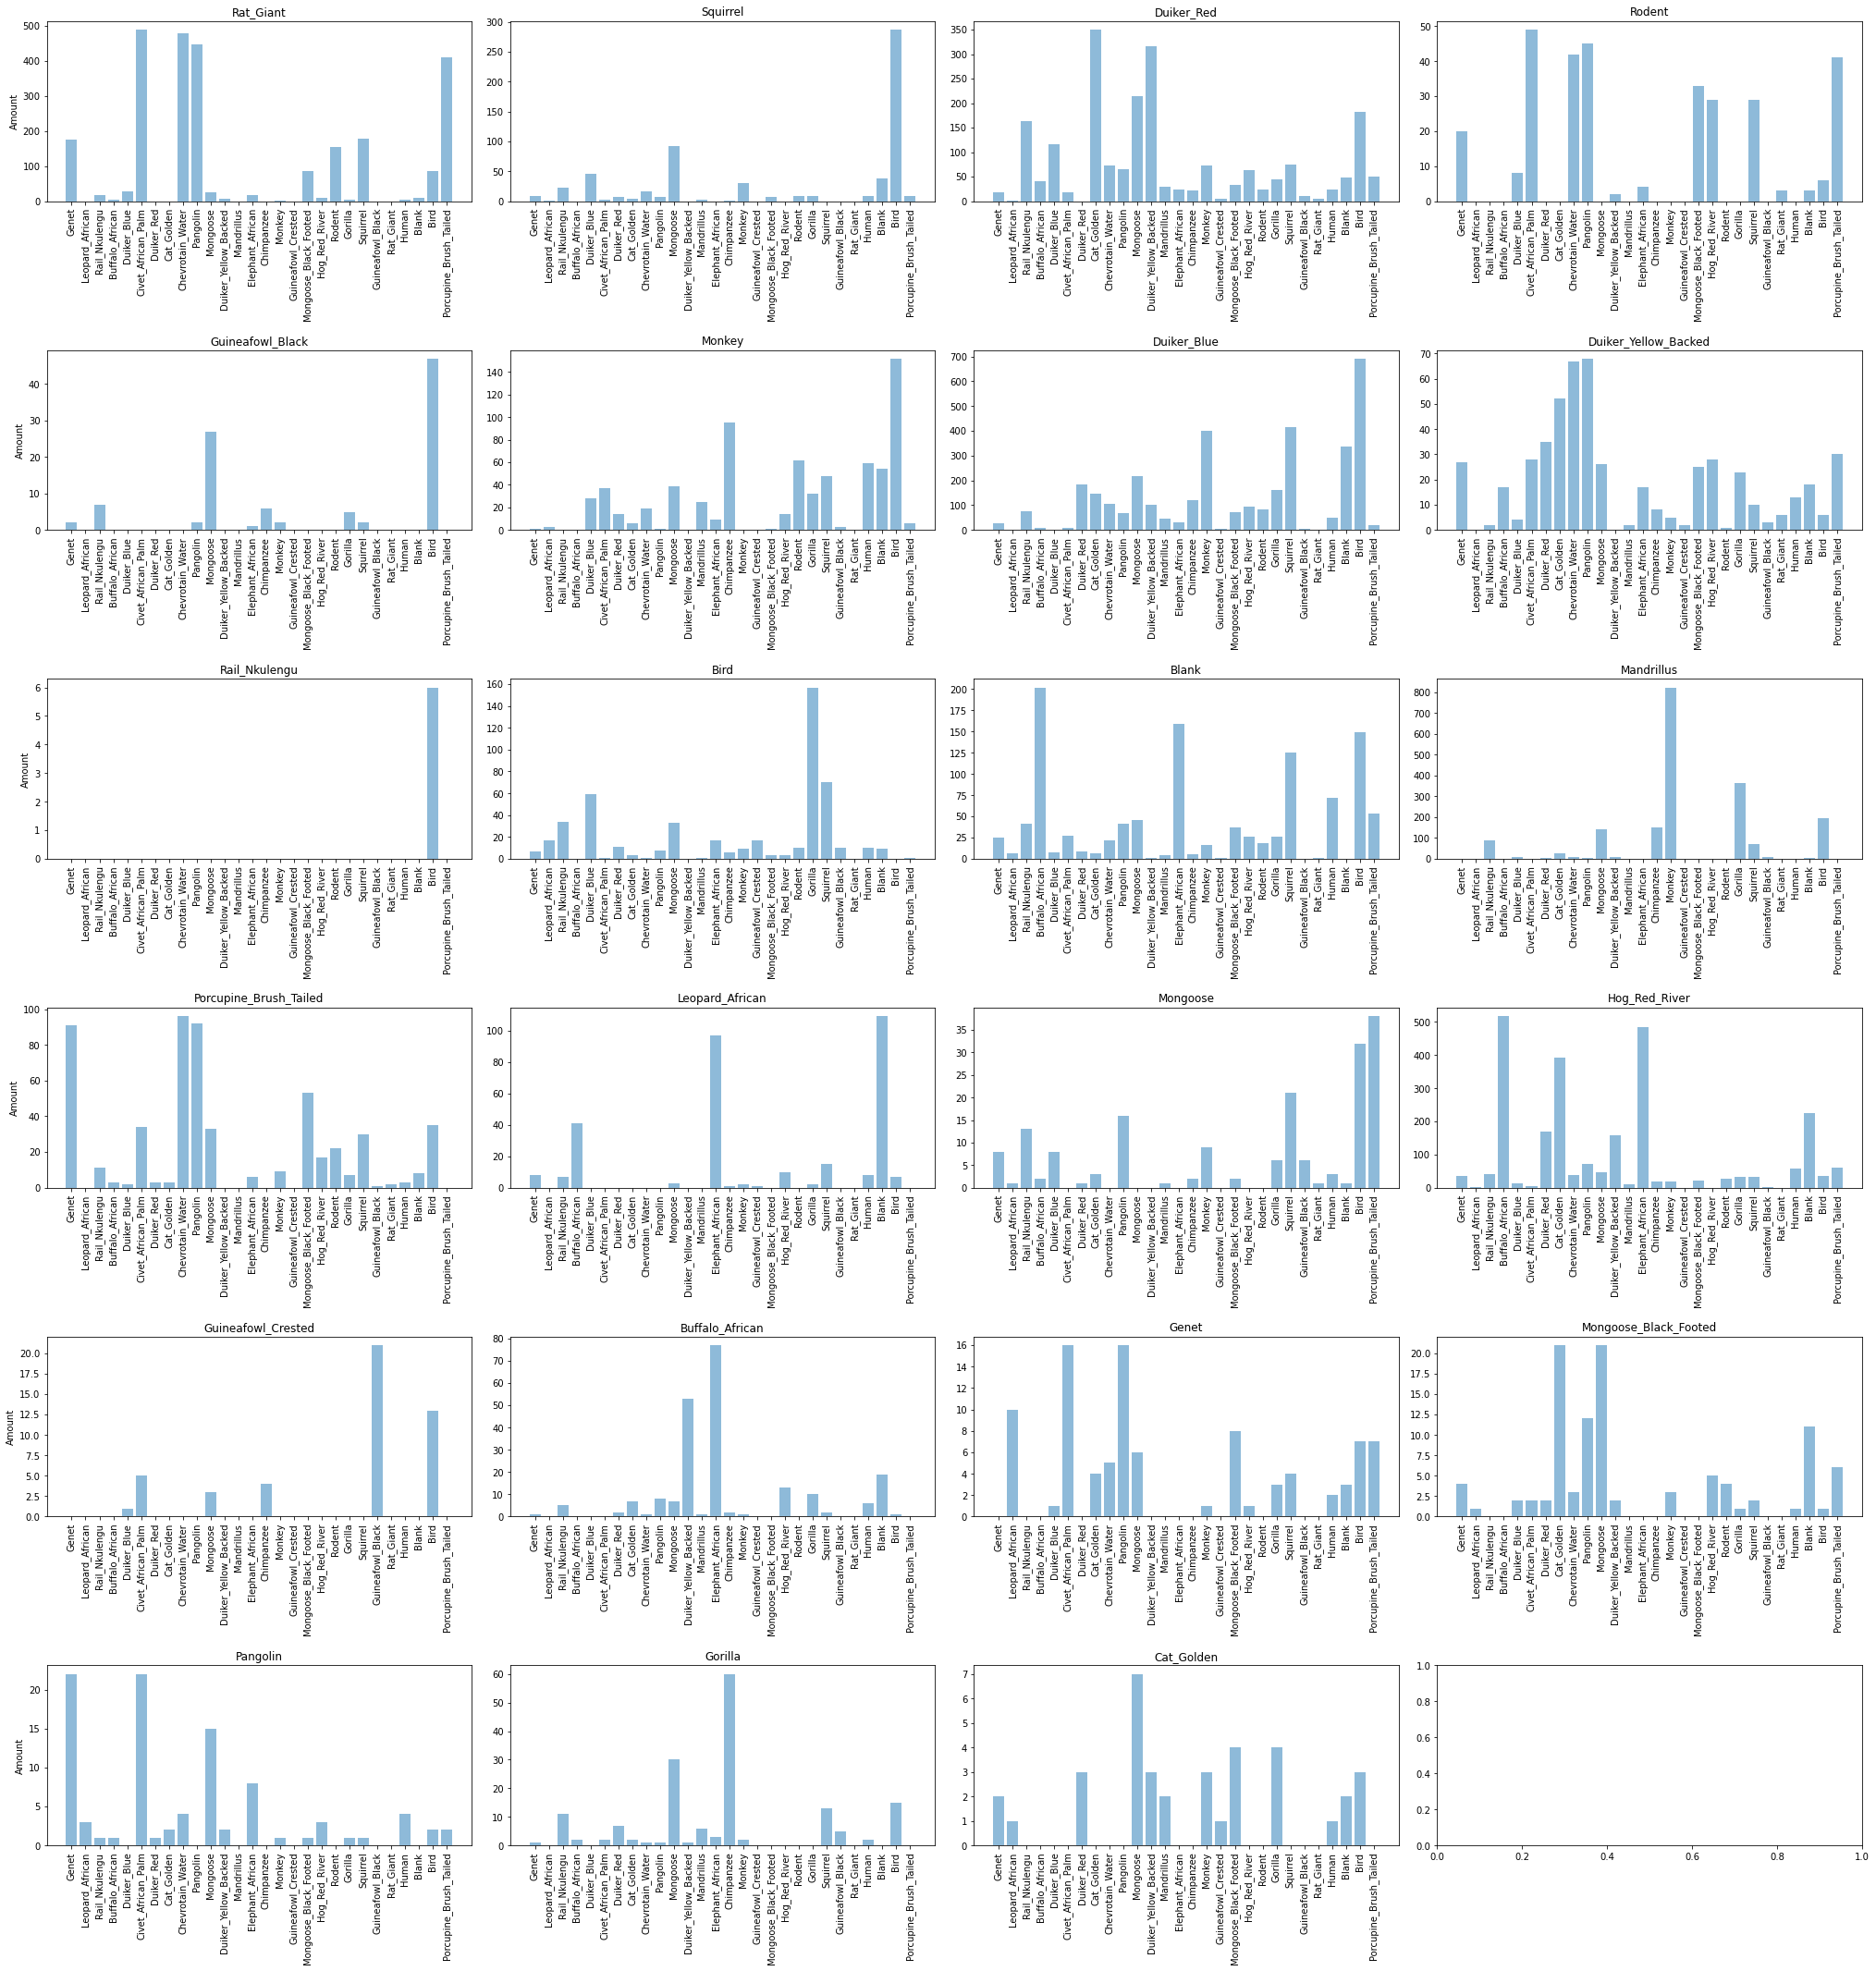

In [52]:
y_pos = np.arange(len(CLASS_NAMES))
f, axarr = plt.subplots(7,4, figsize=(28,28))
f.tight_layout(h_pad=14)

col = 0
row = 0
for name in prediction_dict.keys():
    if col < 4:
        axarr[row][col].bar(y_pos, prediction_dict[name], align='center', alpha=0.5, tick_label=CLASS_NAMES)
        axarr[row][col].set_title(name)
        axarr[row][col].set_xticklabels(CLASS_NAMES, rotation=90)
        axarr[row][0].set_ylabel('Amount')
        col += 1
    else:
        row += 1
        col = 0
        axarr[row][col].bar(y_pos, prediction_dict[name], align='center', alpha=0.5, tick_label=CLASS_NAMES)
        axarr[row][col].set_title(name)
        axarr[row][col].set_xticklabels(CLASS_NAMES, rotation=90)
        axarr[row][0].set_ylabel('Amount')
        col += 1
        

In [49]:
amount = train_data.copy()
amount["n"] = 1
amount = amount[[0, "n"]]
amount.groupby(0).sum()
# train_data.groupby(0)

,n
0,
Bird,23710
Blank,23956
Buffalo_African,24130
Cat_Golden,24840
Chevrotain_Water,24227
Chimpanzee,24798
Civet_African_Palm,24344
Duiker_Blue,23997
Duiker_Red,23945


In [1]:
# plt.ion()
# index = 0
# for idx, i in enumerate(test_ds):   
#     for j in i[0]:
# #         if y_pred[index][y_pred[index].argmax()] > 0.99:
#         if predicted_categories[index].numpy() != true_categories[index]:
#             plt.figure(figsize = (16,16))
#             plt.imshow(j)
#             plt.show()
#             print("Prediction: "+ str(CLASS_NAMES[predicted_categories[index].numpy()]))
#             print("True: "+ str(CLASS_NAMES[true_categories[index]]))
#         index+=1

# Saves

FileNotFoundError: [Errno 2] No such file or directory: 'gs://dataset-gabon/train_val_test_csv_Siebren/Confusion_matrix/MobileNetV2_5epoch_0.719acc.png'

# Results

MobileNetV2 | 3 epochs training | test acc 0.713 | batch size 128 |

In [ ]:
MobileNetV2 | 5 epochs training | test acc 0.719 | batch size 128 |

In [ ]:
Xception    | 3 epochs training | val acc 0.754  | batch size 128 |

In [ ]:
Xception    | 5 epochs training | val acc 0.761  | batch size 128 |

In [ ]:
Xception    | 5+1 epochs training | val acc 0.765  | batch size 128 |